In [1]:
# Boilerplate at top of file
%load_ext autoreload

%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
from ggplot import *


### Custom
import nltk
import sys
sys.path.append('../')
import cleaner
from feature_eng import FeatureFactory
import random

Loading global tagger... please wait a few seconds


In [111]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor

from sklearn.linear_model import LinearRegression,  Lasso, LassoCV, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

[autoreload of requests.packages.urllib3.packages.six failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: 'NoneType' object has no attribute 'tkinter_messagebox'
]
[autoreload of requests.packages.urllib3 failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name exceptions
]
[autoreload of boto failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: 'module' object has no attribute 'plugin'
]
[autoreload of requests.packages failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/IPython/extensio

In [235]:
ff = FeatureFactory(set_params=False)

In [236]:
def rmse(clf, x, y): 
    return mean_squared_error(clf.predict(x), y)**0.5
def rmse_score(clf, x, y): 
    # grid search does maximization
    return -mean_squared_error(clf.predict(x), y)**0.5

In [237]:
df_train_full = pd.read_csv('../data/train_features/train_features_full.csv')

# smaller ssample size for test_purposes

df_train = df_train_full


In [238]:
df_train = df_train.iloc[random.sample(df_train.index,2000)].reset_index()



In [239]:
df_train= pd.read_csv('../data/train_sample_features.csv')

In [240]:
# df_train = pd.read_csv('../data/esa_features_sample.csv')
# df_train = df_train.fillna(0)

In [241]:
## Constants
Y_KEY = 'relevance'
feat_cols = ff.get_feature_names()
# feat_cols = feat_cols + ['ESA_0', 'ESA_025', 'ESA_05', 'ESA_075', 'ESA_Max', 'Is_High_ESA']

In [242]:
feat_cols

['NumOfWordsInSearchTerm',
 'NumOfCharsInSearchTerm',
 'NumOfWordsInTitle',
 'NumOfCharsInTitle',
 'NumOfWordsInProdDescrip',
 'NumOfCharsInProdDescrip',
 'NumOfCharsInBrand',
 'SearchAndTitleMatch',
 'SearchAndTitleNAdjMatch',
 'SearchAndDescriptionMatch',
 'SearchAndDescriptionNAdjMatch',
 'SearchAndProductBrandMatch',
 'SearchAndProductBulletsMatch',
 'SearchAndProductSizeMatch',
 'SearchAndProductWeightMatch',
 'SearchAndProductSizeInRange',
 'SearchAndProductWeightInRange',
 'SearchAndProductLastWordMatch',
 'SearchAndProductLastWordNAdjMatch',
 'SearchAndTitleDominantNadjMatch',
 'RatioOfDescripToSearch',
 'RatioOfTitleToSearch',
 'SearchDominantWord2VecSimilarityMean',
 'SearchDominantWord2VecSimilarityMin',
 'SearchDominantWord2VecSimilarityMedian',
 'SearchDominantWord2VecSimilarityMax',
 'SearchDominantWord2VecSimilarityPhraseSimilarity',
 'SearchTitleWord2VecSimilarityMean',
 'SearchTitleWord2VecSimilarityMin',
 'SearchTitleWord2VecSimilarityMedian',
 'SearchTitleWord2VecSim

In [243]:
# from itertools import combinations
# list(combinations(feat_cols, 2))
# def generate_interaction_effects(df, feat_cols):
    
#     for col_0, col_1 in combinations(feat_cols, 2):
#         new_col = '%s_with_%s' % (col_0, col_1)
#         df[new_col] = np.multiply(df[col_0], df[col_1])
#         feat_cols.append(new_col)
#     return feat_cols
# feat_cols = generate_interaction_effects(df_train, feat_cols)        

In [244]:
def apse_k_fold(clfs, x, y, k = 10, 
                m_metric = lambda x,y : mean_squared_error(x,y)**0.5,
                verbose=False,
               feature_selection = lambda df, x_col, y_col: (np.array(df[x_col]), np.array(df[y_col]))
               ):
    # all uses the same folds
    # for RMSE
    n = len(y)

    X = np.array(x)
    y = np.array(y)

    print X.shape
    kf = KFold(n, n_folds=k)

#     X = np.array(df[x_col])
#     y = np.array(df[y_col])
    results = []
    for clf in clfs:
        if verbose:
            print '%s-Fold Cross Validation for %s' % (k, clf.__class__.__name__)
        fm = clone(clf).fit(X, y)
        apses = []
        varias =  []
        for train_index, test_index in kf:
        #     print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            fm_y_pred = fm.predict(X_test)
            var = m_metric(y_test, fm_y_pred)
            apse = m_metric(y_test, y_pred)
            apses.append(apse)
            varias.append(var)
#             mse = m_metric(fm_y_pred, y_)
            if verbose:
                print "APSE", apse, "Variance", var
        results.append(dict(
            classifier = clf.__class__.__name__,
            params = clf.get_params(),
            apse_mean = np.mean(apses),
            var_mean = np.mean(varias),
            ))
    return pd.DataFrame(results)
from sklearn.feature_selection import f_regression
def feature_selection(df, x_col, y_col):
    kbest = SelectKBest(f_regression, k=5)
    X =  kbest.fit_transform(df[x_col], df[y_col])
    Y = df[y_col]
    return X,Y

In [245]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
print_full(df_train['SearchTitleWord2VecSimilarityPhraseSimilarity'])


0      0.861249
1      0.792258
2      0.688922
3      0.587112
4      0.515990
5      0.907788
6      0.460787
7      0.677537
8      0.780565
9      0.849171
10     0.497496
11     0.803876
12     0.425217
13     0.713525
14     0.802542
15     0.627890
16     0.654938
17     0.712916
18     0.802513
19     0.274580
20     0.559146
21     0.725858
22     0.807824
23     0.554596
24     0.891164
25     0.675686
26     0.344051
27     0.900580
28     0.511523
29     0.759591
30     0.814426
31     0.526884
32     0.830181
33     0.590732
34     0.554686
35     0.814382
36     0.637167
37     0.844081
38     0.587466
39     0.650805
40     0.279677
41     0.479170
42     0.756165
43     0.810550
44     0.835356
45     0.758487
46     0.639356
47     0.343456
48     0.686560
49     0.321931
50     0.460218
51     0.430014
52     0.837248
53     0.714288
54     0.656921
55     0.581131
56     0.791937
57     0.810718
58     0.872229
59     0.953996
60     0.562478
61     0.632542
62     0

In [246]:
rf = RandomForestRegressor()
lm = LinearRegression()
lasso = LassoCV()
gbr = GradientBoostingRegressor()
bgr = BaggingRegressor()
knn = KNeighborsRegressor()
# apse_k_fold(rf, df_train, feat_cols, Y_KEY)


df_res = apse_k_fold(
    [rf, lm, lasso, gbr, bgr, knn], 
#     [svr],
    df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)
df_res

(1000, 37)


,apse_mean,classifier,params,var_mean
0,0.488317,RandomForestRegressor,"{u'warm_start': False, u'oob_score': False, u'...",0.210334
1,0.479863,LinearRegression,"{u'copy_X': True, u'normalize': False, u'n_job...",0.460641
2,0.483706,LassoCV,"{u'normalize': False, u'alphas': None, u'n_job...",0.474740
3,0.479528,GradientBoostingRegressor,"{u'warm_start': False, u'loss': u'ls', u'verbo...",0.351758
4,0.503206,BaggingRegressor,"{u'max_samples': 1.0, u'base_estimator': None,...",0.209856
5,0.566275,KNeighborsRegressor,"{u'n_neighbors': 5, u'algorithm': u'auto', u'm...",0.453725


# visualize

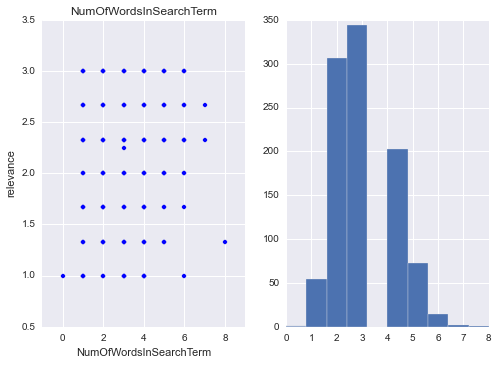

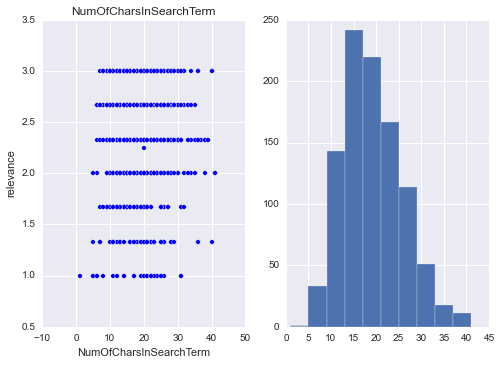

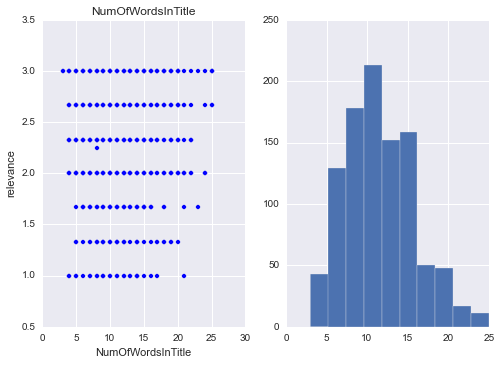

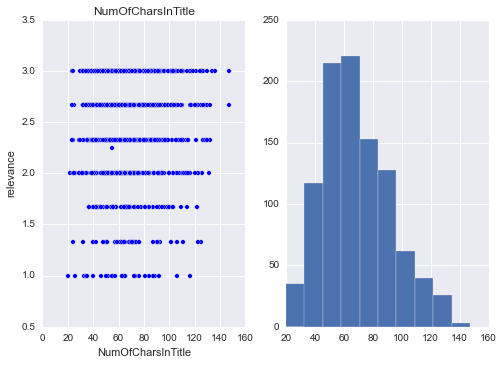

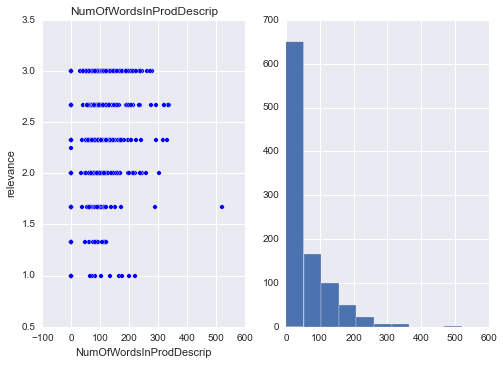

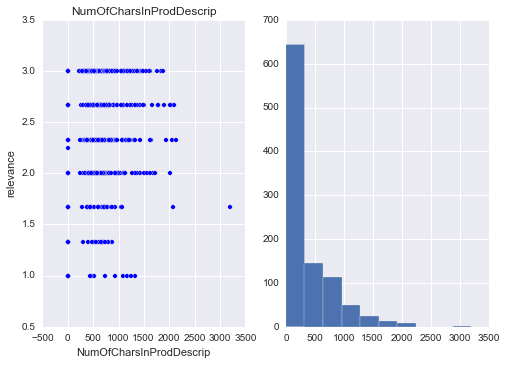

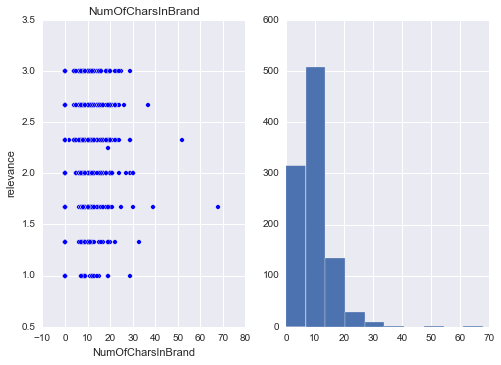

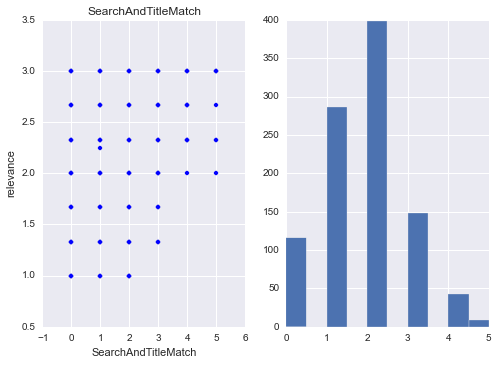

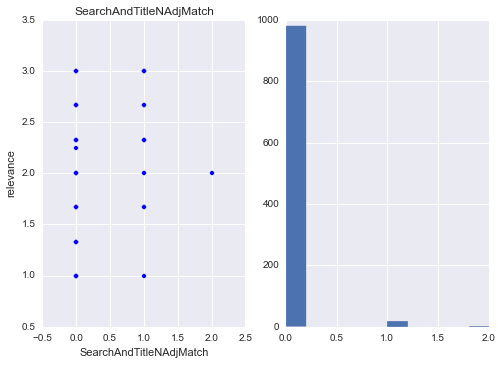

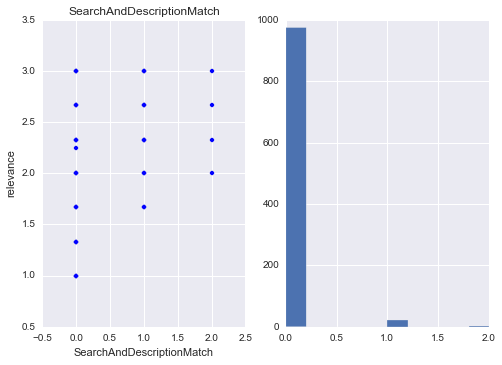

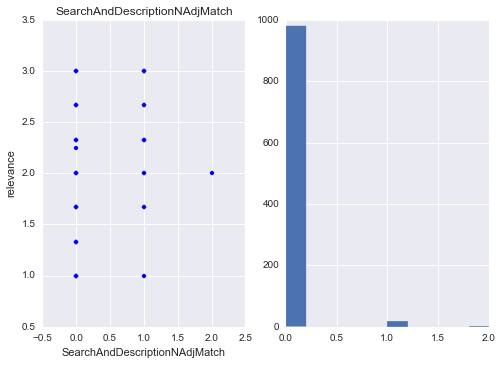

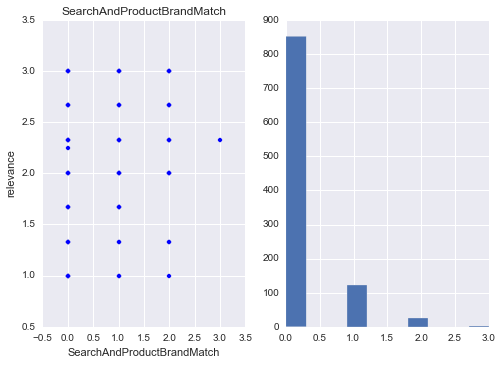

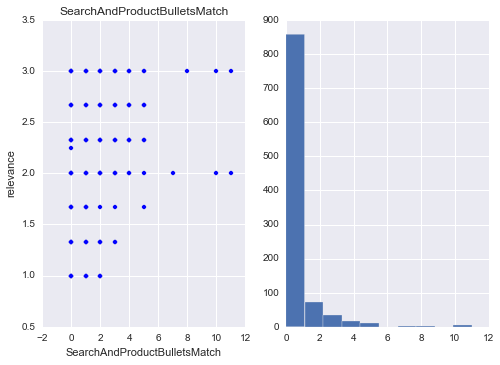

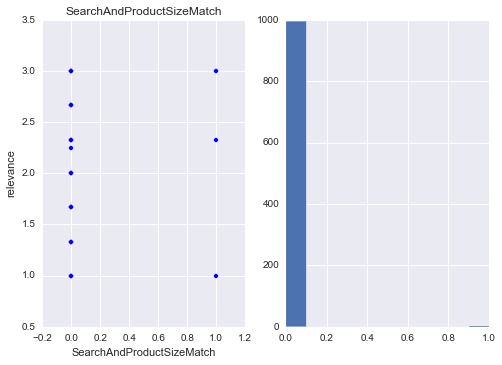

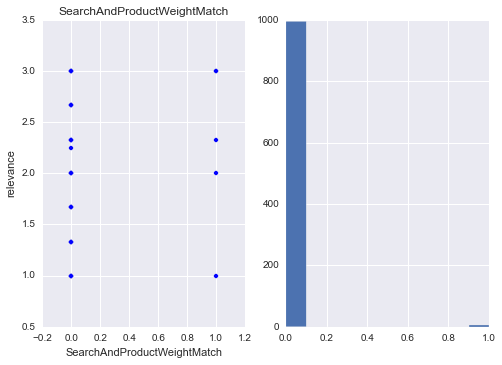

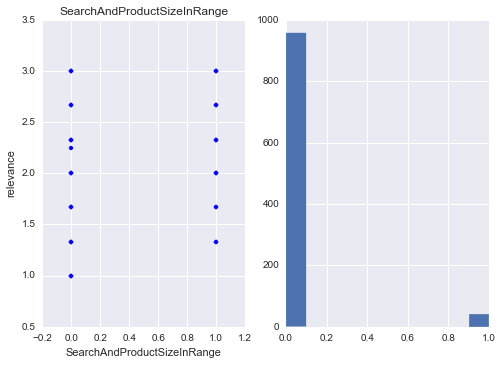

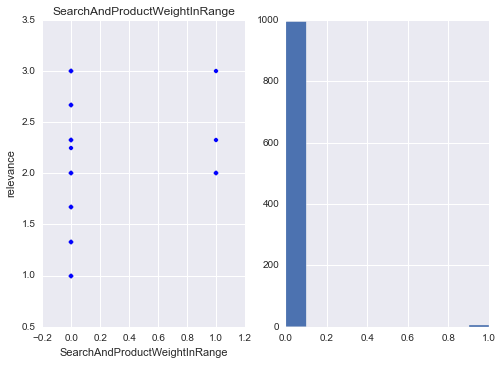

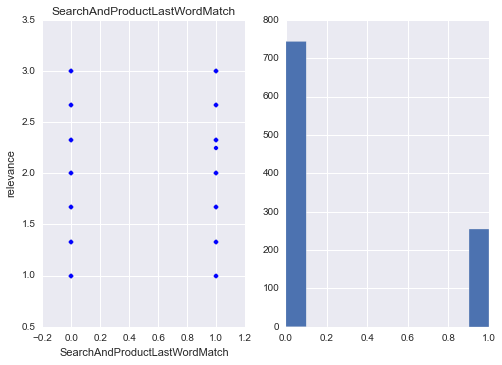

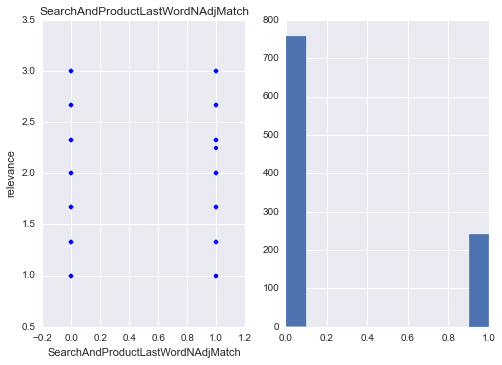

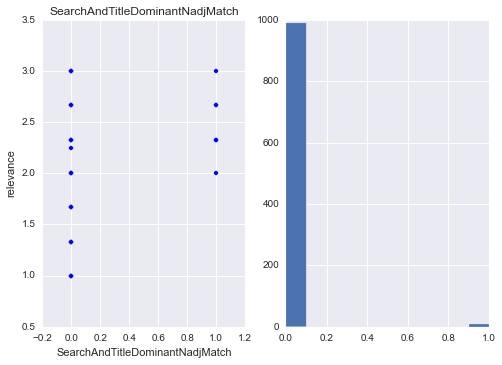

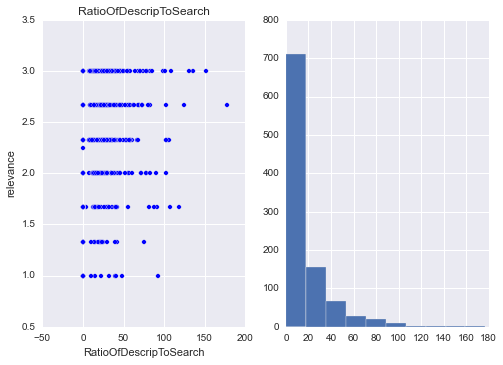

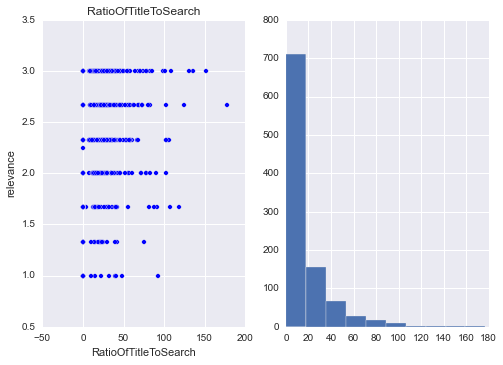

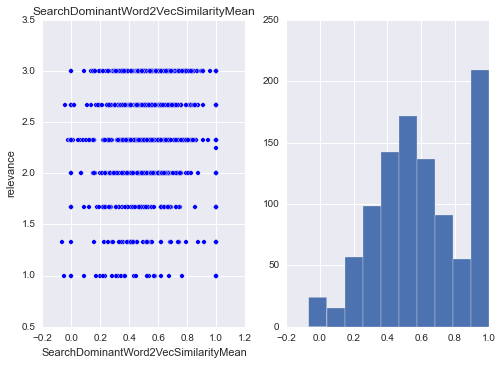

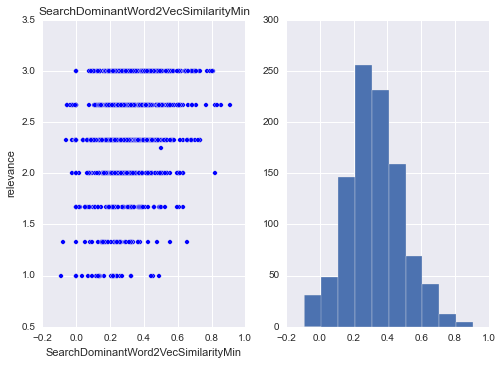

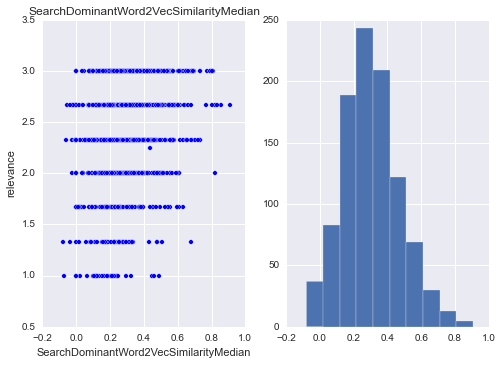

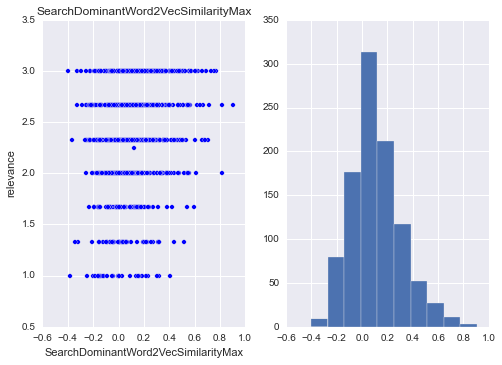

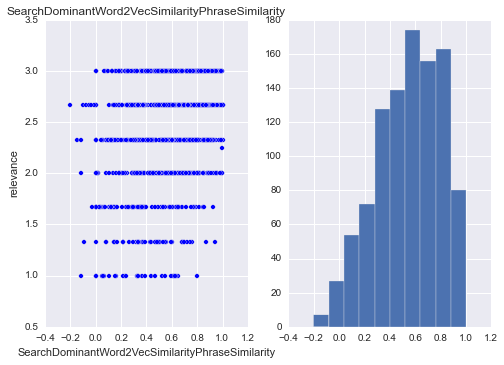

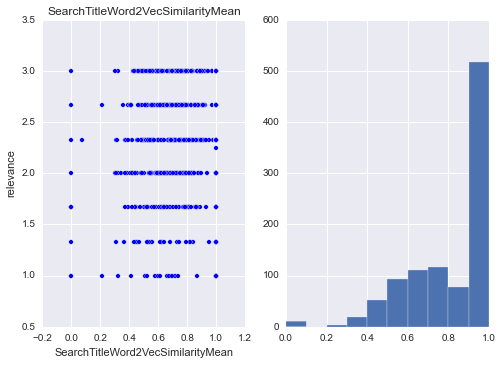

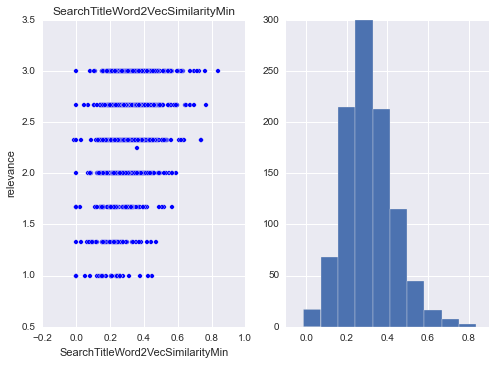

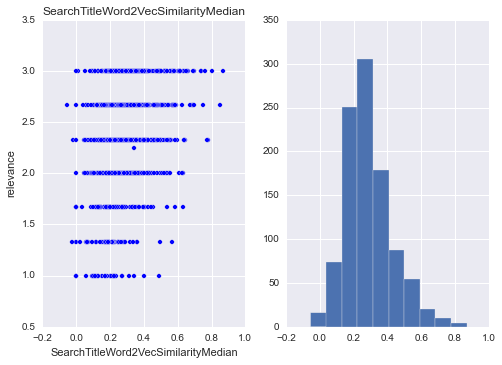

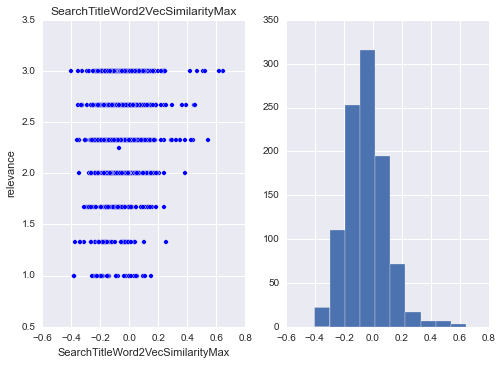

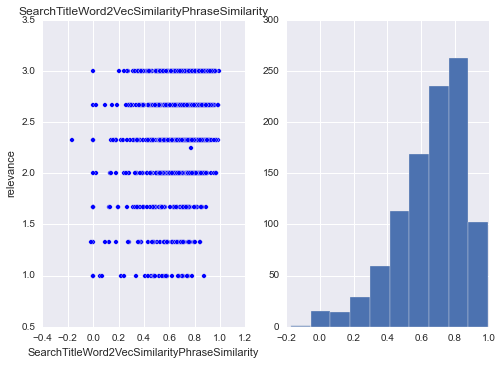

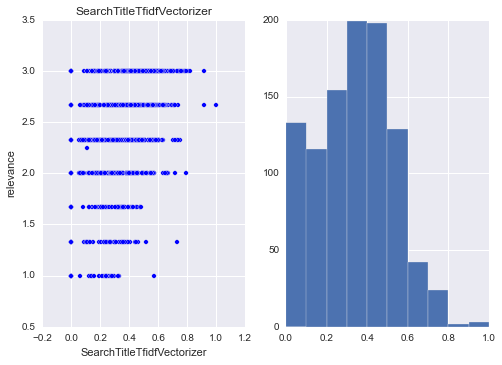

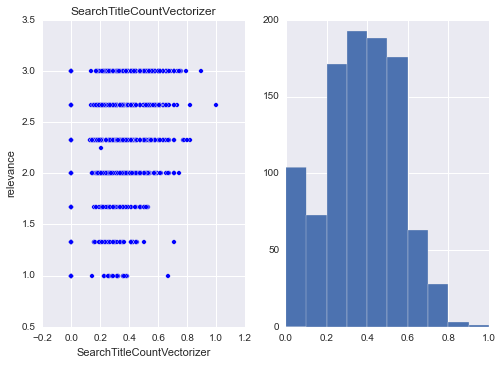

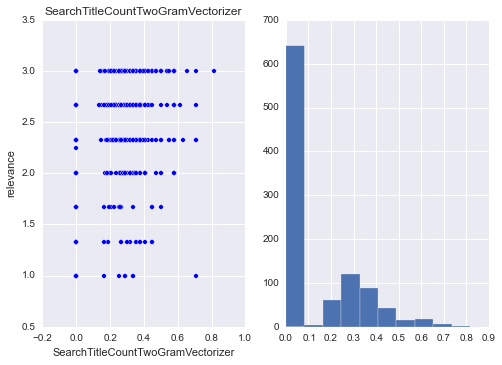

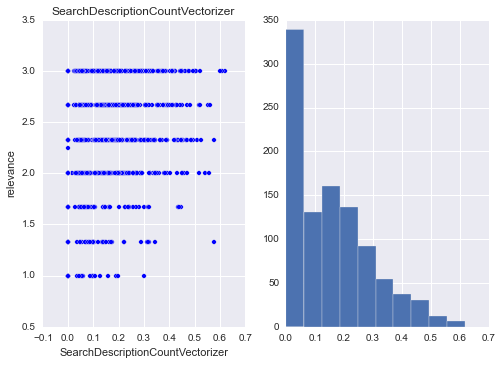

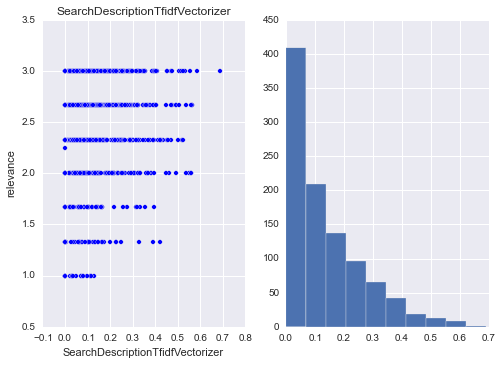

In [247]:
for f in feat_cols:
    plt.figure()
    plt.subplot(121)
    plt.scatter(df_train[f], df_train[Y_KEY])
    plt.title(f)
    plt.xlabel(f)
    plt.ylabel(Y_KEY)
    plt.subplot(122)
    plt.hist(df_train[f])

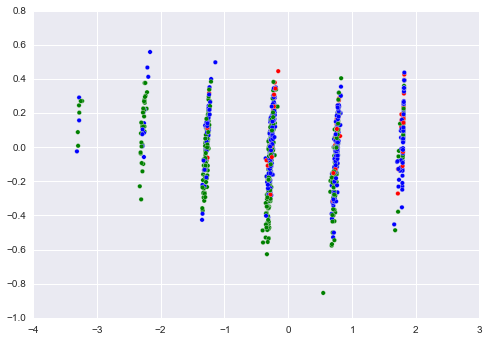

In [221]:
from sklearn.lda import LDA
from sklearn.decomposition import TruncatedSVD,PCA

lda = LDA()
svd = TruncatedSVD(n_components=2)
pca = PCA(n_components=2)
X, Y = feature_selection(df_train, feat_cols, Y_KEY)
Y = np.round(Y) - 1
X = pca.fit_transform(X,Y)

colors=['red', 'blue', 'green']
plt.scatter(X[:,0], X[:,1], c = map(lambda x: colors[int(x)], Y))

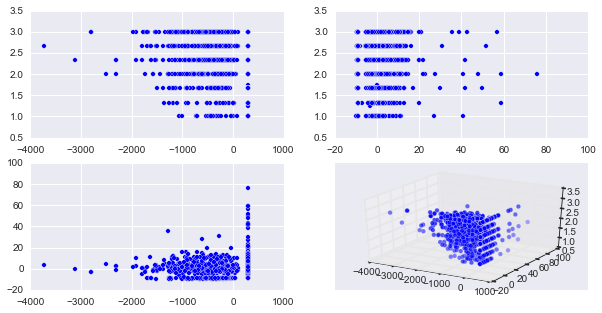

In [33]:
from mpl_toolkits.mplot3d import Axes3D
def decomp_scatter_3d(X, Y, decomp):
    args = [Y]
    X_decomp = decomp.fit_transform(X,*args)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(221)
    ax.scatter(X_decomp[:,0], Y)
    ax = fig.add_subplot(222)    
    ax.scatter(X_decomp[:,1], Y)
    ax = fig.add_subplot(223)    
    ax.scatter(X_decomp[:,0], X_decomp[:,1])
    
    
    ax = fig.add_subplot(224, projection='3d')
    ax.scatter(X_decomp[:,0], X_decomp[:,1], Y)
X_min  = SelectKBest(f_regression, k = 10).fit_transform(df_train[feat_cols], df_train[Y_KEY])

decomp_scatter_3d(X_min,df_train[Y_KEY], pca)

# Gradient Boosting Regression

In [248]:
steps = [('kbest', SelectKBest(f_regression)),
        ('clf', GradientBoostingRegressor())]
params = {
    'kbest__k' : list(xrange(5,len(feat_cols)-1)),
#     'kbest__k' : [21,22],
    'clf__n_estimators' : [20, 30, 50, 75, 100],
}
pipeline = Pipeline(steps)
from sklearn.grid_search import GridSearchCV
gs_boost = GridSearchCV(pipeline, params, n_jobs=5, verbose=1, scoring=rmse_score)
gs_boost.fit(df_train[feat_cols], df_train[Y_KEY])
# apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)

Fitting 3 folds for each of 155 candidates, totalling 465 fits


[Parallel(n_jobs=5)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  50 jobs       | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 200 jobs       | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 450 jobs       | elapsed:   17.1s
[Parallel(n_jobs=5)]: Done 457 out of 465 | elapsed:   17.7s remaining:    0.3s
[Parallel(n_jobs=5)]: Done 465 out of 465 | elapsed:   18.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x114bc0cf8>)), ('clf', GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=5,
       param_grid={'kbest__k': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 'clf__n_estimators': [20, 30, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=<function rmse_score at 0x118708e60>, verbose=1)

In [249]:
gs_boost.best_score_

-0.48246223322531612

In [250]:
gs_boost.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=31, score_func=<function f_regression at 0x114bc0cf8>)), ('clf', GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=30,
             random_state=None, subsample=1.0, verbose=0, warm_start=False))])

In [251]:
apse_k_fold([gs_boost.best_estimator_, pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)

(1000, 37)


,apse_mean,classifier,params,var_mean
0,0.473396,Pipeline,"{u'clf__init': None, u'clf__n_estimators': 30,...",0.414057
1,0.490044,Pipeline,"{u'clf__init': None, u'clf__n_estimators': 100...",0.371157


In [252]:
gs_boost.grid_scores_

[mean: -0.48972, std: 0.02095, params: {'kbest__k': 5, 'clf__n_estimators': 20},
 mean: -0.48949, std: 0.01969, params: {'kbest__k': 6, 'clf__n_estimators': 20},
 mean: -0.48888, std: 0.02040, params: {'kbest__k': 7, 'clf__n_estimators': 20},
 mean: -0.48897, std: 0.01754, params: {'kbest__k': 8, 'clf__n_estimators': 20},
 mean: -0.48868, std: 0.01712, params: {'kbest__k': 9, 'clf__n_estimators': 20},
 mean: -0.48804, std: 0.01714, params: {'kbest__k': 10, 'clf__n_estimators': 20},
 mean: -0.48828, std: 0.01581, params: {'kbest__k': 11, 'clf__n_estimators': 20},
 mean: -0.48941, std: 0.01683, params: {'kbest__k': 12, 'clf__n_estimators': 20},
 mean: -0.49056, std: 0.01782, params: {'kbest__k': 13, 'clf__n_estimators': 20},
 mean: -0.48971, std: 0.01871, params: {'kbest__k': 14, 'clf__n_estimators': 20},
 mean: -0.48857, std: 0.01766, params: {'kbest__k': 15, 'clf__n_estimators': 20},
 mean: -0.48813, std: 0.01729, params: {'kbest__k': 16, 'clf__n_estimators': 20},
 mean: -0.49023, std:

In [24]:
best_estimator = gs_boost.best_estimator_

# Neurel Net

In [39]:
from sklearn.neural_network import BernoulliRBM

In [50]:

steps = [('rbm', BernoulliRBM()),
        ('clf', LinearRegression())]
pipeline = Pipeline(steps)
apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY])

(2000, 24)


,apse_mean,classifier,params,var_mean
0,0.532333,Pipeline,"{u'rbm__verbose': 0, u'clf': LinearRegression(...",0.531907


In [56]:
ra = pipeline.steps[0][1]

# Linear Regression

In [253]:
steps = [('kbest', SelectKBest(f_regression)),
        ('clf', LinearRegression())]
params = {
    'kbest__k' : list(xrange(5,len(feat_cols)-1)),
#     'kbest__k' : [21,22],
#     'clf__n_estimators' : [20, 30, 50, 75, 100],
}
pipeline = Pipeline(steps)
from sklearn.grid_search import GridSearchCV
gs_lm = GridSearchCV(pipeline, params, n_jobs=5, verbose=1, scoring=rmse_score)
gs_lm.fit(df_train[feat_cols], df_train[Y_KEY])
# apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)

Fitting 3 folds for each of 31 candidates, totalling 93 fits


[Parallel(n_jobs=5)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  50 jobs       | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  85 out of  93 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  93 out of  93 | elapsed:    0.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x114bc0cf8>)), ('clf', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=5,
       param_grid={'kbest__k': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=<function rmse_score at 0x118708e60>, verbose=1)

In [254]:
gs_lm.grid_scores_

[mean: -0.48491, std: 0.01922, params: {'kbest__k': 5},
 mean: -0.48456, std: 0.01751, params: {'kbest__k': 6},
 mean: -0.48328, std: 0.01808, params: {'kbest__k': 7},
 mean: -0.48356, std: 0.01785, params: {'kbest__k': 8},
 mean: -0.48416, std: 0.01814, params: {'kbest__k': 9},
 mean: -0.48394, std: 0.01715, params: {'kbest__k': 10},
 mean: -0.48317, std: 0.01621, params: {'kbest__k': 11},
 mean: -0.48237, std: 0.01712, params: {'kbest__k': 12},
 mean: -0.48231, std: 0.01714, params: {'kbest__k': 13},
 mean: -0.48184, std: 0.01849, params: {'kbest__k': 14},
 mean: -0.48130, std: 0.01861, params: {'kbest__k': 15},
 mean: -0.47982, std: 0.01644, params: {'kbest__k': 16},
 mean: -0.48050, std: 0.01582, params: {'kbest__k': 17},
 mean: -0.48026, std: 0.01572, params: {'kbest__k': 18},
 mean: -0.48064, std: 0.01545, params: {'kbest__k': 19},
 mean: -0.47850, std: 0.01343, params: {'kbest__k': 20},
 mean: -0.47841, std: 0.01682, params: {'kbest__k': 21},
 mean: -0.48127, std: 0.01418, param

In [255]:
apse_k_fold([gs_lm.best_estimator_,pipeline], df_train[feat_cols], df_train[Y_KEY])

(1000, 37)


,apse_mean,classifier,params,var_mean
0,0.475937,Pipeline,"{u'clf': LinearRegression(copy_X=True, fit_int...",0.463038
1,0.478365,Pipeline,"{u'clf': LinearRegression(copy_X=True, fit_int...",0.472737


# Support Vector Regressor

Is super slow :(

In [ ]:
# steps = [('kbest', SelectKBest(f_regression)),
#         ('clf', SVR())]
# params = {
#     'kbest__k' : list(xrange(5,len(feat_cols)-1)),
# #     'kbest__k' : [21,22],
#     'clf__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
# }
# pipeline = Pipeline(steps)
# from sklearn.grid_search import GridSearchCV
# gs_svr = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1, scoring=rmse_score)
# gs_svr.fit(df_train[feat_cols], df_train[Y_KEY])
# # apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)


Fitting 3 folds for each of 90 candidates, totalling 270 fits


# Random Forest

In [256]:
steps = [('kbest', SelectKBest(f_regression)),
        ('clf', RandomForestRegressor())]
params = {
    'kbest__k' : list(xrange(20,len(feat_cols)-1)),
    'clf__n_estimators' : [30],
}
pipeline = Pipeline(steps)
from sklearn.grid_search import GridSearchCV
gs_rf = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1, scoring=rmse_score)
gs_rf.fit(df_train[feat_cols], df_train[Y_KEY])
# apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  42 out of  48 | elapsed:    4.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    5.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x114bc0cf8>)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'kbest__k': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 'clf__n_estimators': [30]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=<function rmse_score at 0x118708e60>, verbose=1)

In [257]:
gs_rf.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=27, score_func=<function f_regression at 0x114bc0cf8>)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [258]:
gs_rf.best_score_

-0.48579160796382143

In [259]:
apse_k_fold([gs_rf.best_estimator_, pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)

(1000, 37)


,apse_mean,classifier,params,var_mean
0,0.474407,Pipeline,"{u'clf__n_estimators': 30, u'clf__warm_start':...",0.185253
1,0.507666,Pipeline,"{u'clf__n_estimators': 10, u'clf__warm_start':...",0.223627


In [260]:
gs_rf.grid_scores_

[mean: -0.49671, std: 0.01041, params: {'kbest__k': 20, 'clf__n_estimators': 30},
 mean: -0.49669, std: 0.01165, params: {'kbest__k': 21, 'clf__n_estimators': 30},
 mean: -0.49669, std: 0.01420, params: {'kbest__k': 22, 'clf__n_estimators': 30},
 mean: -0.50040, std: 0.01226, params: {'kbest__k': 23, 'clf__n_estimators': 30},
 mean: -0.49392, std: 0.01531, params: {'kbest__k': 24, 'clf__n_estimators': 30},
 mean: -0.49477, std: 0.01036, params: {'kbest__k': 25, 'clf__n_estimators': 30},
 mean: -0.49451, std: 0.00887, params: {'kbest__k': 26, 'clf__n_estimators': 30},
 mean: -0.48579, std: 0.01700, params: {'kbest__k': 27, 'clf__n_estimators': 30},
 mean: -0.49012, std: 0.01487, params: {'kbest__k': 28, 'clf__n_estimators': 30},
 mean: -0.49222, std: 0.01322, params: {'kbest__k': 29, 'clf__n_estimators': 30},
 mean: -0.49034, std: 0.01737, params: {'kbest__k': 30, 'clf__n_estimators': 30},
 mean: -0.49345, std: 0.01422, params: {'kbest__k': 31, 'clf__n_estimators': 30},
 mean: -0.49698,

# Make a Submission

In [45]:
apse_k_fold([best_estimator],
           df_train_full[feat_cols],
           df_train_full[Y_KEY]
           )

(74067, 24)


,apse_mean,classifier,params,var_mean
0,0.487941,Pipeline,"{u'clf__init': None, u'clf__n_estimators': 30,...",0.485822


In [46]:

best_estimator.fit(df_train_full[feat_cols], df_train_full[Y_KEY])

Pipeline(steps=[('kbest', SelectKBest(k=22, score_func=<function f_regression at 0x10e8d8cf8>)), ('clf', GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=30,
             random_state=None, subsample=1.0, verbose=0, warm_start=False))])

In [47]:
df_test = pd.read_csv('../data/test_features/test_features_full.csv')

In [48]:
y_test = best_estimator.predict(df_test[feat_cols])

(array([  56.,   90.,    0.,  187.,    0.,  314.,  408.,    2.,  426.,  517.]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <a list of 10 Patch objects>)

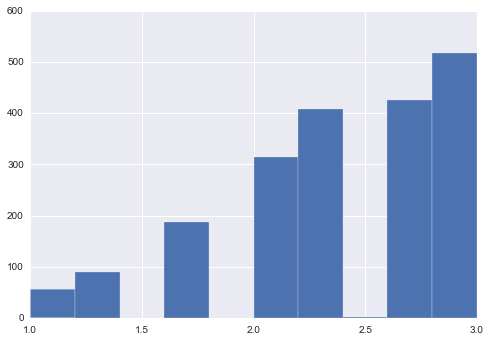

In [49]:
plt.hist(np.power(df_train[Y_KEY],1))

(array([   863.,   3945.,   8777.,  20619.,  27535.,  30208.,  30232.,
         23026.,  16782.,   4706.]),
 array([ 1.85424446,  1.94769979,  2.04115511,  2.13461044,  2.22806576,
         2.32152108,  2.41497641,  2.50843173,  2.60188706,  2.69534238,
         2.78879771]),
 <a list of 10 Patch objects>)

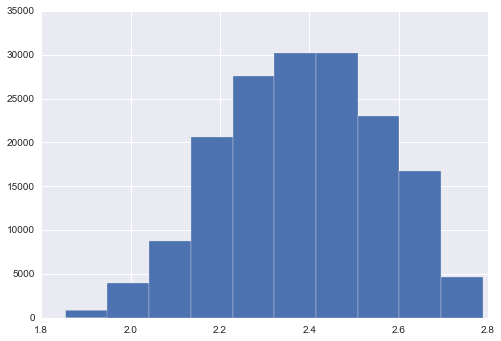

In [50]:
plt.hist(y_test)

In [51]:
df_test_submission = pd.DataFrame(dict(id = df_test['id'], relevance=y_test))

In [52]:
df_test_submission.to_csv('submission.csv', index=False)

In [53]:
df_test_raw = pd.read_csv('../data/test.csv')

In [42]:
df_test_joined = pd.read_csv('../data/test_joined.csv')

In [43]:
ids_a = set(df_test_joined['id'].tolist())
ids_b = set(df_test_raw['id'].tolist())

In [44]:
ids_a.difference(ids_b)

set()